In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import pickle
import cv2



2025-07-02 19:51:19.087718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751485879.323846      34 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751485879.389160      34 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

dataset_path = "/kaggle/input/animalshakil/dataset"
classes = os.listdir(dataset_path)


class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    class_counts[class_name] = len(os.listdir(class_path))


print("Dataset Information:")
print(f"Total number of classes: {len(classes)}")
print("Classes:", classes)
print("\nNumber of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")
print(f"\nTotal images in dataset: {sum(class_counts.values())}")

Dataset Information:
Total number of classes: 5
Classes: ['lamb', 'dog', 'zebra', 'cow', 'cat']

Number of images per class:
lamb: 107 images
dog: 105 images
zebra: 108 images
cow: 101 images
cat: 111 images

Total images in dataset: 532


In [ ]:
# Define image size
IMG_WIDTH, IMG_HEIGHT = 64, 64


def load_and_preprocess_images(dataset_path, classes, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            
            
            image = cv2.imread(image_path)
            image = cv2.resize(image, img_size)
         
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            
            images.append(image)
            labels.append(class_idx)
    
    return np.array(images), np.array(labels)

X, y = load_and_preprocess_images(dataset_path, classes)
y_one_hot = to_categorical(y, num_classes=len(classes))

print("\nPreprocessed Data Shapes:")
print("Images shape:", X.shape)
print("Labels shape:", y_one_hot.shape)


Preprocessed Data Shapes:
Images shape: (532, 64, 64, 3)
Labels shape: (532, 5)


In [ ]:

datagen = ImageDataGenerator(
    rotation_range=40,         
    width_shift_range=0.2,     
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True,       
    fill_mode='nearest',        
    brightness_range=[0.5, 1.5] 
)


datagen.fit(X)

augmented_images = []
augmented_labels = []
num_augmented_per_image = 2  

for i in range(len(X)):
    img = X[i].reshape((1,) + X[i].shape)
    aug_iter = datagen.flow(img, batch_size=1)
    for j in range(num_augmented_per_image):
        augmented_img = next(aug_iter)[0]
        augmented_images.append(augmented_img)
        augmented_labels.append(y[i])

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

X_combined = np.concatenate((X, augmented_images))
y_combined = np.concatenate((y, augmented_labels))
y_combined_one_hot = to_categorical(y_combined, num_classes=len(classes))

print("\nAfter Augmentation:")
print("Original number of images:", len(X))
print("Number of augmented images:", len(augmented_images))
print("Combined dataset size:", len(X_combined))


After Augmentation:
Original number of images: 532
Number of augmented images: 1064
Combined dataset size: 1596


In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined, y_combined_one_hot, test_size=0.3, random_state=42, stratify=y_combined)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

print("\nDataset Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Dataset Split:
Training set: 1117 samples
Validation set: 239 samples
Test set: 240 samples


In [ ]:

X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_val_flatten = X_val.reshape(X_val.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

print("\nFlattened Shapes:")
print("Training:", X_train_flatten.shape)
print("Validation:", X_val_flatten.shape)
print("Test:", X_test_flatten.shape)


Flattened Shapes:
Training: (1117, 12288)
Validation: (239, 12288)
Test: (240, 12288)


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

class LogisticRegressionWithEpochs:
    def __init__(self, n_epochs=10, batch_size=32, learning_rate=0.01):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = SGDClassifier(
            loss='log_loss',  
            penalty='l2',
            learning_rate='constant',
            eta0=learning_rate,
            max_iter=1,
            warm_start=False,
            random_state=42,
            verbose=0
        )
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_loss_history = []
        self.val_loss_history = []
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
       
        self.model.partial_fit(X_train[:1], y_train[:1], classes=np.unique(y_train))
        
        for epoch in range(self.n_epochs):
            indices = np.random.permutation(len(X_train))
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
          
            for i in range(0, len(X_train), self.batch_size):
                batch = slice(i, i + self.batch_size)
                self.model.partial_fit(X_shuffled[batch], y_shuffled[batch])
            
           
            train_pred = self.model.predict(X_train)
            train_acc = accuracy_score(y_train, train_pred)
            self.train_acc_history.append(train_acc)
            
            if X_val is not None and y_val is not None:
                val_pred = self.model.predict(X_val)
                val_acc = accuracy_score(y_val, val_pred)
                self.val_acc_history.append(val_acc)
            
            print(f"Epoch {epoch+1}/{self.n_epochs} - Train Acc: {train_acc:.4f}", end="")
            if X_val is not None and y_val is not None:
                print(f" - Val Acc: {val_acc:.4f}")
            else:
                print()
    
    def predict(self, X):
        return self.model.predict(X)


logreg = LogisticRegressionWithEpochs(
    n_epochs=10,
    batch_size=64,
    learning_rate=0.01
)


y_train_class = np.argmax(y_train, axis=1)
y_val_class = np.argmax(y_val, axis=1)
y_test_class = np.argmax(y_test, axis=1)


logreg.fit(X_train_flatten, y_train_class, X_val_flatten, y_val_class)

Epoch 1/10 - Train Acc: 0.3330 - Val Acc: 0.2845
Epoch 2/10 - Train Acc: 0.3286 - Val Acc: 0.2845
Epoch 3/10 - Train Acc: 0.2901 - Val Acc: 0.2301
Epoch 4/10 - Train Acc: 0.4118 - Val Acc: 0.2887
Epoch 5/10 - Train Acc: 0.3957 - Val Acc: 0.2803
Epoch 6/10 - Train Acc: 0.4351 - Val Acc: 0.3138
Epoch 7/10 - Train Acc: 0.4091 - Val Acc: 0.2720
Epoch 8/10 - Train Acc: 0.4494 - Val Acc: 0.2929
Epoch 9/10 - Train Acc: 0.4584 - Val Acc: 0.2971
Epoch 10/10 - Train Acc: 0.4414 - Val Acc: 0.2845


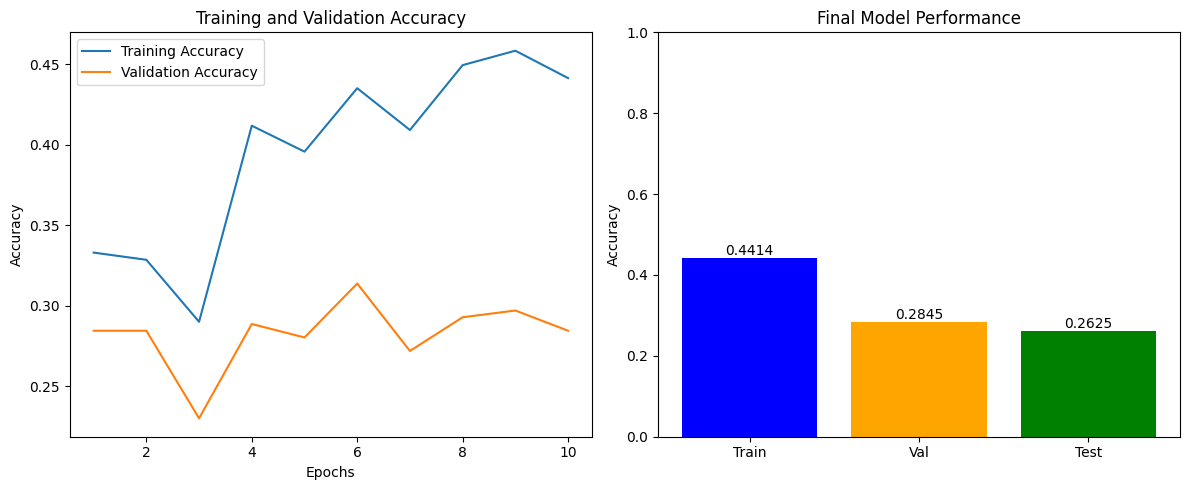


Test Accuracy: 0.2625

Classification Report:
              precision    recall  f1-score   support

        lamb       0.55      0.12      0.20        48
         dog       0.37      0.27      0.31        48
       zebra       0.19      0.63      0.30        49
         cow       0.32      0.18      0.23        45
         cat       0.62      0.10      0.17        50

    accuracy                           0.26       240
   macro avg       0.41      0.26      0.24       240
weighted avg       0.41      0.26      0.24       240



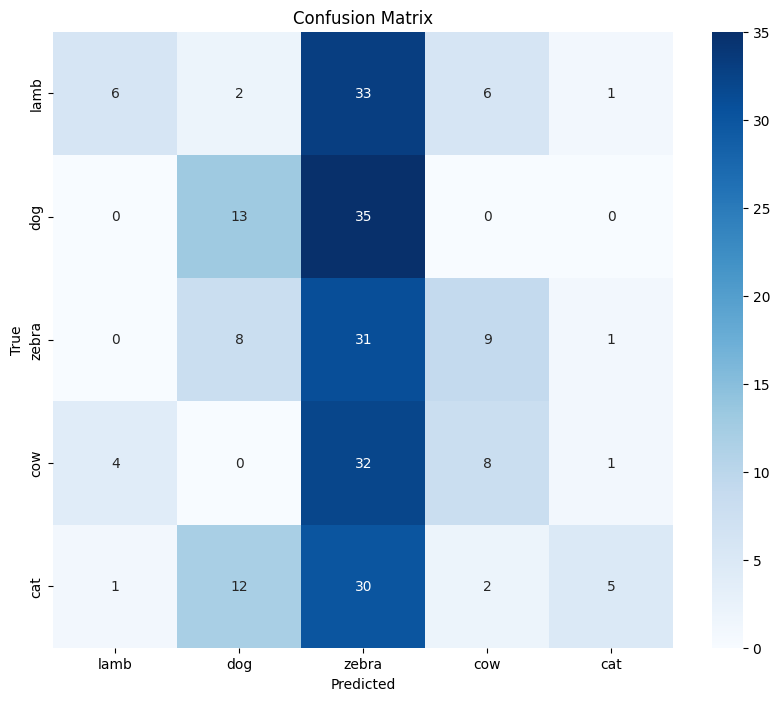

In [ ]:
# Plot 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), logreg.train_acc_history, label='Training Accuracy')
plt.plot(range(1, 11), logreg.val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
test_pred = logreg.predict(X_test_flatten)
test_acc = accuracy_score(y_test_class, test_pred)


metrics = ['Train', 'Val', 'Test']
values = [
    logreg.train_acc_history[-1],
    logreg.val_acc_history[-1],
    test_acc
]
colors = ['blue', 'orange', 'green']

bars = plt.bar(metrics, values, color=colors)
plt.ylabel('Accuracy')
plt.title('Final Model Performance')
plt.ylim(0, 1.0)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


print("\nTest Accuracy:", test_acc)
print("\nClassification Report:")
print(classification_report(y_test_class, test_pred, target_names=classes))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_class, test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Dataset Augmentation Comparison:


,Total Images,Images per Class (Avg),Minimum Class Count,Maximum Class Count,Class Imbalance Ratio,Change
Before Augmentation,532,106.4,101,111,1.09901,NaN
After Augmentation,1596,319.2,303,333,1.09901,NaN


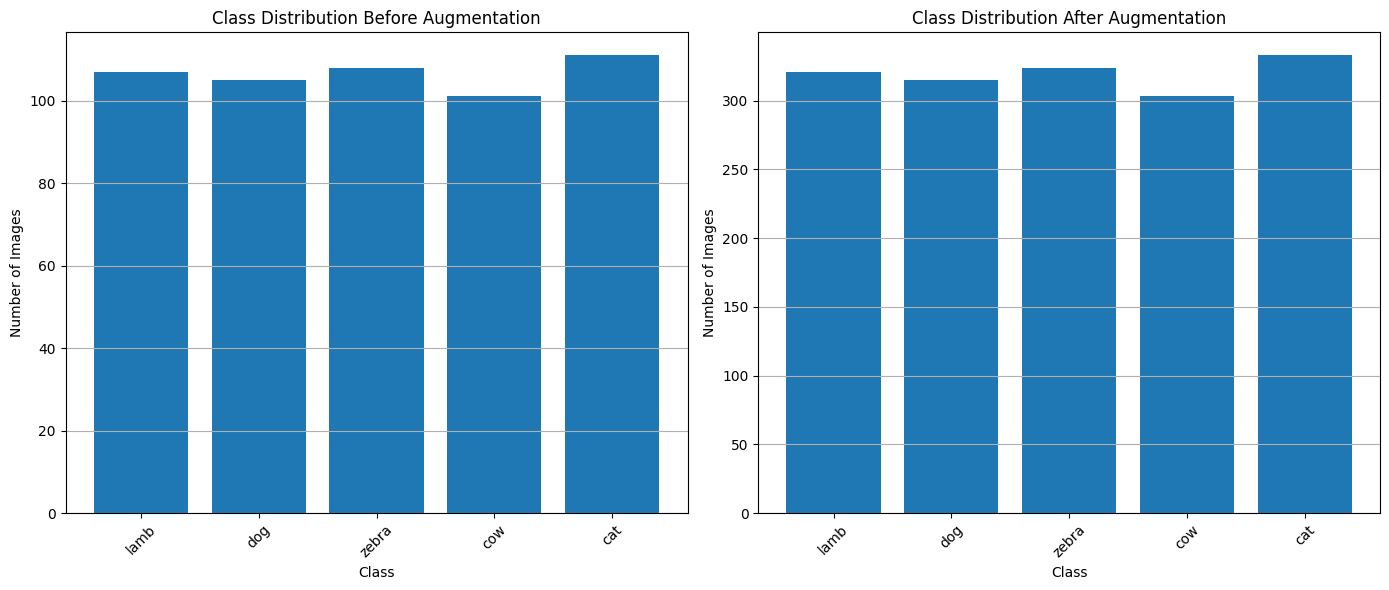


Class-by-Class Comparison:


,Class,Original Count,Augmented Count,Increase,Increase %
0,lamb,107,321,214,200.0
1,dog,105,315,210,200.0
2,zebra,108,324,216,200.0
3,cow,101,303,202,200.0
4,cat,111,333,222,200.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts


original_counts = count_images_per_class("/kaggle/input/animalshakil/dataset")
original_total = sum(original_counts.values())


augmented_counts = dict(zip(classes, np.bincount(y_combined)))
augmented_total = len(X_combined)


metrics = {
    'Total Images': [original_total, augmented_total],
    'Images per Class (Avg)': [
        np.mean(list(original_counts.values())),
        np.mean(list(augmented_counts.values()))
    ],
    'Minimum Class Count': [
        min(original_counts.values()),
        min(augmented_counts.values())
    ],
    'Maximum Class Count': [
        max(original_counts.values()),
        max(augmented_counts.values())
    ],
    'Class Imbalance Ratio': [
        max(original_counts.values())/min(original_counts.values()),
        max(augmented_counts.values())/min(augmented_counts.values())
    ]
}


comparison_df = pd.DataFrame(metrics, index=['Before Augmentation', 'After Augmentation'])
comparison_df['Change'] = comparison_df.pct_change().iloc[1].apply(lambda x: f"{x:.1%}")

print("Dataset Augmentation Comparison:")
display(comparison_df)

# Visualization
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.bar(original_counts.keys(), original_counts.values())
plt.title('Class Distribution Before Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(True, axis='y')


plt.subplot(1, 2, 2)
plt.bar(augmented_counts.keys(), augmented_counts.values())
plt.title('Class Distribution After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


class_comparison = pd.DataFrame({
    'Class': list(original_counts.keys()),
    'Original Count': list(original_counts.values()),
    'Augmented Count': [augmented_counts[c] for c in original_counts.keys()],
})
class_comparison['Increase'] = class_comparison['Augmented Count'] - class_comparison['Original Count']
class_comparison['Increase %'] = (class_comparison['Increase'] / class_comparison['Original Count']) * 100

print("\nClass-by-Class Comparison:")
display(class_comparison)